In [49]:
import json
import os
import datetime
import numpy as np


In [ ]:
class SampleTimestamps():

    def __init__(self, file_path = "/media/dbogdoll/Datasets/aws_s3_playground/sip-data-stream2-delivery-stream-2-2024-04-12-16-08-52-b39d2153-114e-3f15-8e67-66651d357768", target_framerate_hz = 1, aws_bucket=None, aws_prefix=None, ):
        self.file_path = file_path
        self.aws_bucket = aws_bucket
        self.aws_prefix = aws_prefix
        self.target_framerate_hz = target_framerate_hz
        self.valid_target_framerate = True
        self.current_framerate_hz = None
        self.timestamps = []

        if file_path:
            self.execution_mode = "local"
        elif aws_bucket and aws_prefix:
            self.execution_mode = "aws"
        else:
            raise ValueError("Either file_path or aws_bucket and aws_prefix must be provided")

    def get_framerate(self
    ):
        current_framerate_hz = None
        timestamps = []

        with open(self.file_path, "r") as file:
            for index, line in enumerate(file):
                data = json.loads(line)
                v51_sample = {}
                if "time" in data and "data" in data:
                    # Get time data
                    timestamp_raw = data.get("time")
                    timestamp = datetime.datetime.strptime(timestamp_raw, "%Y-%m-%d %H:%M:%S.%f")

                elif (
                    "image" in data
                    and "sensor_name" in data
                    and "event_timestamp" in data
                ):
                    # Get time data
                    timestamp_raw = data.get("event_timestamp")
                    timestamp = datetime.datetime.fromtimestamp(timestamp_raw, tz=datetime.timezone.utc)

                timestamps.append((index, timestamp))

        # Calculate current framerate
        time_differences = []
        timestamps = sorted(timestamps, key=lambda x: x[1])

        previous_michigan_time = None
        for index, timestamp in timestamps:
            if previous_michigan_time is not None:
                time_difference = (timestamp - previous_michigan_time).total_seconds()
                time_differences.append(time_difference)
            previous_michigan_time = timestamp

        # Statistics about timestamp distribution
        average_time_diff = np.mean(time_differences)
        median_time_diff = np.median(time_differences)
        std_time_diff = np.std(time_differences)
        min_time_diff = np.min(time_differences)
        max_time_diff = np.max(time_differences)
        range_time_diff = max_time_diff - min_time_diff
        q1_time_diff = np.percentile(time_differences, 25)
        q3_time_diff = np.percentile(time_differences, 75)
        current_framerate_hz = 1 / median_time_diff # Median is more robust to outliers

        print(f"Average time difference between timestamps: {"{:.3f}".format(average_time_diff)} seconds")
        print(f"Median time difference between timestamps: {"{:.3f}".format(median_time_diff)} seconds")
        print(f"Standard deviation of time differences: {"{:.3f}".format(std_time_diff)} seconds")
        print(f"25th percentile (Q1) of time differences: {"{:.3f}".format(q1_time_diff)} seconds")
        print(f"75th percentile (Q3) of time differences: {"{:.3f}".format(q3_time_diff)} seconds")
        print(f"Min time difference between timestamps: {"{:.3f}".format(min_time_diff)} seconds")
        print(f"Max time difference between timestamps: {"{:.3f}".format(max_time_diff)} seconds")
        print(f"Range of time differences: {"{:.3f}".format(range_time_diff)} seconds")
        print(f"Current framerate: {"{:.3f}".format(current_framerate_hz)} Hz")

    def _check_target_framerate(self, current_framerate_hz):
        # Check if target framerate is valid
        if self.target_framerate_hz > current_framerate_hz:
            print(f"Target framerate of {self.target_framerate_hz} Hz cannot exceed original framerate of {current_framerate_hz} Hz")
            return False
        else:
            return True



        

Average time difference between timestamps: 0.241 seconds
Median time difference between timestamps: 0.229 seconds
Standard deviation of time differences: 0.071 seconds
25th percentile (Q1) of time differences: 0.193 seconds
75th percentile (Q3) of time differences: 0.278 seconds
Min time difference between timestamps: 0.129 seconds
Max time difference between timestamps: 1.158 seconds
Range of time differences: 1.028 seconds
Current framerate: 4.371 Hz


In [ ]:
sampler = SampleTimestamps()
current_framerate_hz = sampler.get_framerate()
valid_target_framerate = sampler._check_target_framerate(current_framerate_hz)
if valid_target_framerate:
    sampler.resample_timestamps()
    sampler.write_resampled_timestamps()

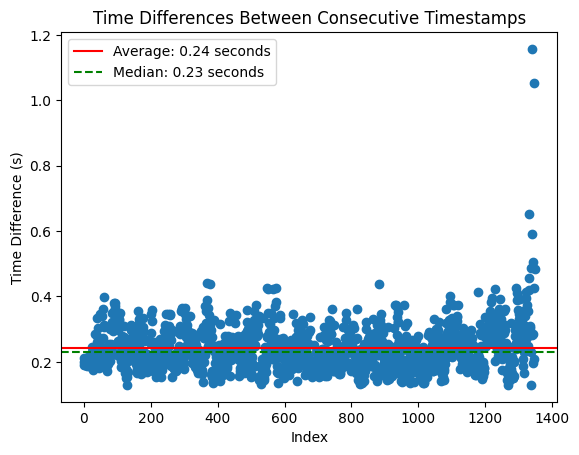

In [51]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(time_differences))
plt.scatter(x, time_differences)

# Calculate average and median
average_time_diff = np.mean(time_differences)
median_time_diff = np.median(time_differences)

plt.axhline(y=average_time_diff, color='r', linestyle='-', label=f'Average: {average_time_diff:.2f} seconds')
plt.axhline(y=median_time_diff, color='g', linestyle='--', label=f'Median: {median_time_diff:.2f} seconds')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Time Difference (s)')
plt.title('Time Differences Between Consecutive Timestamps')
plt.legend()

# Show the plot
plt.show()

In [52]:
# Step 1: Generate target timestamps (1 Hz sampling)
start_time = timestamps[0]
end_time = timestamps[-1]
target_timestamps = []
current_time = start_time
while current_time <= end_time:
    target_timestamps.append(current_time)
    current_time += datetime.timedelta(seconds=1)

In [57]:
from tqdm import tqdm

threshold_to_target = 0.2  # seconds

# Find nearest original timestamps to target_timestamps_seconds
selected_indices = []
selected_timestamps = []
selected_values = []

min_time_diffs = []

for target in tqdm(target_timestamps, desc = "Finding nearest timestamps"):
    # Compute the time difference with each original timestamp
    time_diffs = [(target - t).total_seconds() for t in timestamps]  # Stay in datetime
    time_diffs = np.abs(time_diffs)  # Take absolute differences
    
    # Find the index of the nearest timestamp
    nearest_index = np.argmin(time_diffs)
    min_time_diffs.append(time_diffs[nearest_index])

    # Print warning for outliers but keep them
    if time_diffs[nearest_index] > threshold_to_target:
        print(f"Warning: Nearest timestamp is {time_diffs[nearest_index]:.2f} seconds away from target")

    # Ensure no duplicates are selected
    if nearest_index not in selected_indices:
        selected_indices.append(nearest_index)
        selected_timestamps.append(timestamps[nearest_index])

print(len(timestamps))
print(len(target_timestamps))
print(len(selected_timestamps))

Finding nearest timestamps: 100%|██████████| 326/326 [00:00<00:00, 7294.05it/s]

1350
326
326


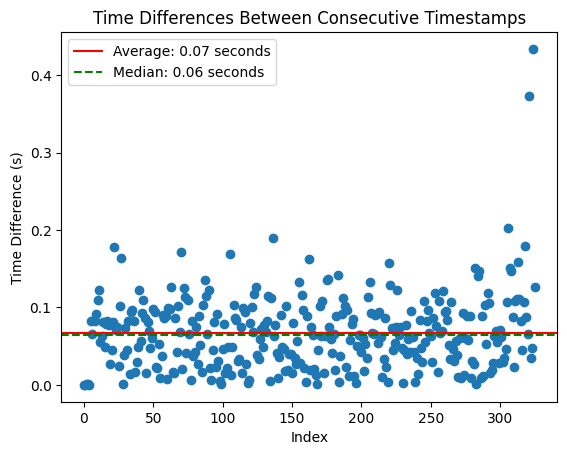

In [54]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(min_time_diffs))
plt.scatter(x, min_time_diffs)

# Calculate average and median
average_time_diff = np.mean(min_time_diffs)
median_time_diff = np.median(min_time_diffs)

plt.axhline(y=average_time_diff, color='r', linestyle='-', label=f'Average: {average_time_diff:.2f} seconds')
plt.axhline(y=median_time_diff, color='g', linestyle='--', label=f'Median: {median_time_diff:.2f} seconds')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Time Difference (s)')
plt.title('Time Differences Between Consecutive Timestamps')
plt.legend()

# Show the plot
plt.show()

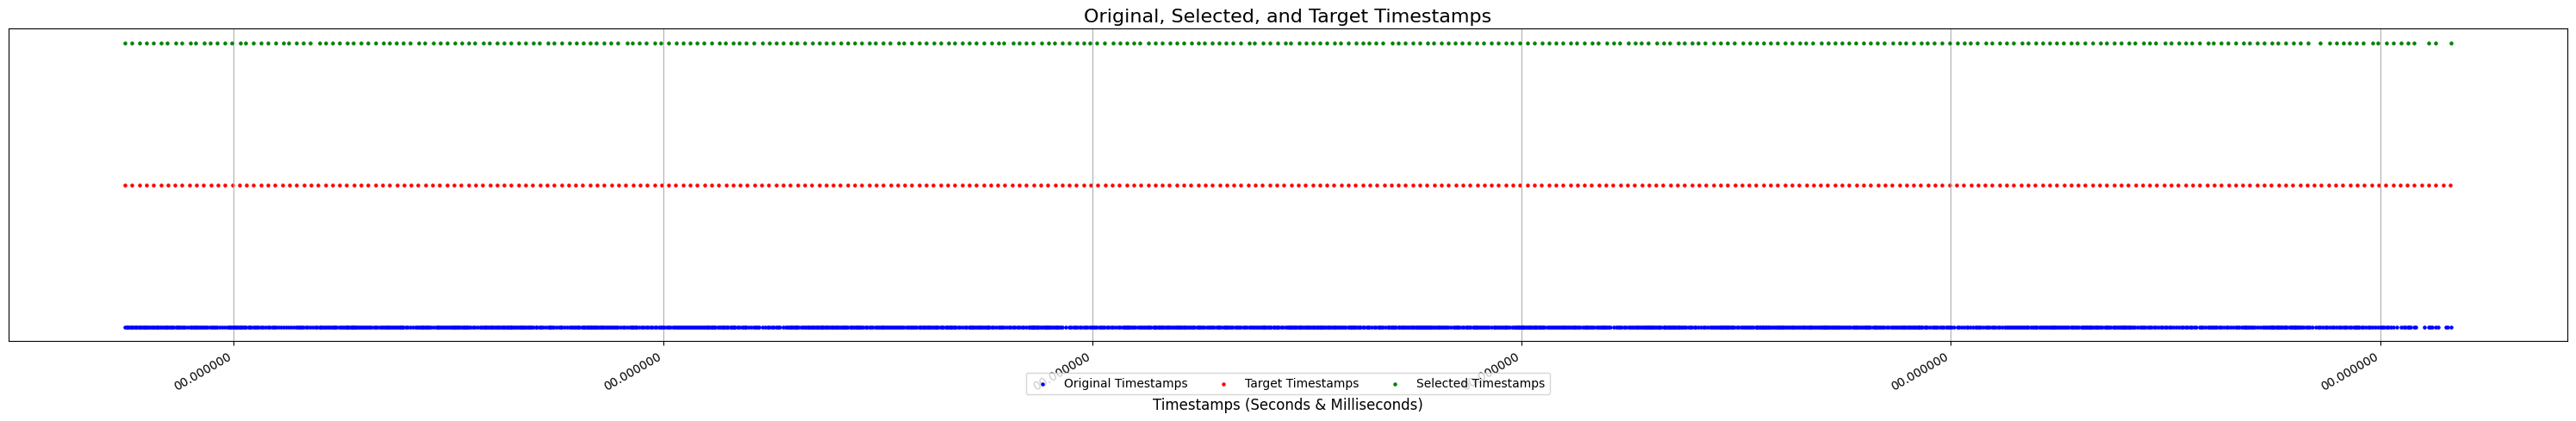

In [55]:
from matplotlib.dates import DateFormatter

# Plotting
fig, ax = plt.subplots(figsize=(30, 5))

# Convert datetime lists to matplotlib-compatible formats
original_times = timestamps
selected_times = selected_timestamps

# Scatter plot for original timestamps
ax.scatter(
    timestamps, [1] * len(timestamps),
    color='blue', label='Original Timestamps', s=5, zorder=2
)

# Scatter plot for target timestamps (green dots)
ax.scatter(
    target_timestamps, [1.01] * len(target_timestamps),
    color='red', label='Target Timestamps', s=5, zorder=1
)

# Scatter plot for selected timestamps
ax.scatter(
    selected_timestamps, [1.02] * len(selected_timestamps),
    color='green', label='Selected Timestamps', s=5, zorder=3
)

# Formatting the plot
ax.set_title('Original, Selected, and Target Timestamps', fontsize=16)
ax.set_xlabel('Timestamps (Seconds & Milliseconds)', fontsize=12)
ax.set_yticks([])  # Remove y-axis ticks
ax.grid(True)

# Move the legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, borderaxespad=0.)

# Use a DateFormatter for seconds and milliseconds
date_formatter = DateFormatter("%S.%f")  # Show seconds and milliseconds
ax.xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()  # Rotate and format x-axis labels

plt.tight_layout()  # Ensure layout fits with the legend outside
plt.show()